In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, dataset
import os
import glob
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch_snippets import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_ROOT = 'training_images'
df = pd.read_csv('train_solution_bounding_boxes (1).csv')
train_ids, val_ids = train_test_split(df.image.unique(), train_size=0.8, random_state=42)
train_df, val_df = df[df['image'].isin(train_ids)], df[df['image'].isin(val_ids)]
label2target = {'background': 0 , 'car' : 1  }
target2label = { t: l for l,t in  label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)
    return img.to(device).float()

class CarDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        super().__init__()
        self.w, self.h = 224, 224
        self.img_dir = img_dir
        self.files = glob.glob(self.img_dir+'/*')
        self.annotations = df.copy()
        self.transform = transform
        self.images = df.image.unique()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = find(self.images[idx], self.files)
        image = Image.open(image_path).convert('RGB')
        data = self.annotations[self.annotations['image'] == self.images[idx]]
        H, W, _ = np.array(image).shape
        data.loc[:, ['xmin', 'ymin', 'xmax', 'ymax']] /= [W, H, W, H]
        image = np.array(image.resize((self.w, self.h), resample=Image.BILINEAR)) / 255
        label = ['car'] * len(data)
        data = data[['xmin', 'ymin', 'xmax', 'ymax']].values
        data[:, [0, 2]] *= self.w
        data[:, [1, 3]] *= self.h
        boxes = data.astype(np.uint32).tolist()
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in label]).long()
        image = preprocess_image(image)
        return image, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))


In [2]:
train_ds = CarDataset(train_df, IMG_ROOT)
test_ds = CarDataset(val_df , IMG_ROOT)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad()
def validate_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [4]:
model = get_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
epochs = 10

all_train_loss = []
all_val_loss = []

for epoch in range(epochs):
    n = len(train_loader)
    print(f"Epoch {epoch}")
    print("Training phase: ")
    for batch_idx, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_losses, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        # print(f"Batch {batch_idx}/{n} | Train loss: {loss.item()}")
        all_train_loss.append(loss.item())

    n = len(test_loader)
    print("Testing phase: ")
    for batch_idx, inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model, optimizer)
        loc_losses, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        # print(f"Batch {batch_idx}/{n} | Train loss: {loss.item()}")
        all_val_loss.append(loss.item())


c:\Users\minht\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\minht\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0

Training phase:

Testing phase:

Epoch 1

Training phase:

Testing phase:

Epoch 2

Training phase:

Testing phase:

Epoch 3

Training phase:

Testing phase:

Epoch 4

Training phase:

Testing phase:

Epoch 5

Training phase:

In [ ]:
new_train_loss = []
new_val_loss = []
for idx, train_loss in enumerate(all_train_loss):
    if idx % 71 == 0:
        new_train_loss.append(train_loss)

for idx, val_loss in enumerate(all_val_loss):
    if idx % 17 == 0:
        new_val_loss.append(val_loss)

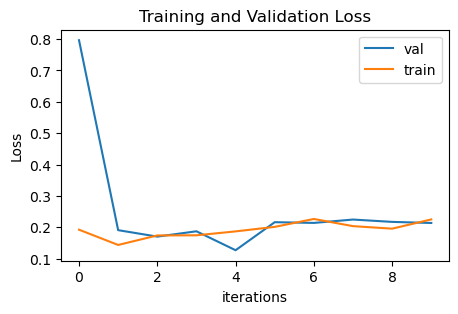

In [ ]:
plt.figure(figsize=(5,3))
plt.title("Training and Validation Loss")
plt.plot(new_train_loss,label="val")
plt.plot(new_val_loss,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    keep_idx = np.where(confs > 0.5)[0]
    bbs, confs, labels = [tensor[keep_idx] for tensor in [bbs, confs, labels]]
    ixs = torchvision.ops.nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

In [ ]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix == 2: break
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l, c in zip(labels, confs)]
        show(images[ix].cpu().permute(1, 2, 0), bbs=bbs, texts=labels, sz=5)

OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 279.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF